## Facies classification using ensemble classifiers 


#### by: <a href="https://ca.linkedin.com/in/evgeny-sorkin-509532b">Evgeny Sorkin</a> [SJ Geophysics](https://www.sjgeophysics.com/)

####  [Original contest notebook](https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)

This notebook demonstrates how to train a machine learning algorithm to predict facies from well log data.  The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a majority-vote classifier comprised of support vector machine, random forest and XGBoosted tree.  We will use the classifiers implementation in [scikit-learn](http://scikit-learn.org) and [XGBoost](https://github.com/dmlc/xgboost)

##  Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `training_data.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 20)
pd.options.mode.chained_assignment = None

filename = '../training_data.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
5,3,A1 SH,SHRIMPLIN,2795.5,73.970,0.636,14.000,13.385,3.600,1,0.894
6,3,A1 SH,SHRIMPLIN,2796.0,73.720,0.630,15.600,13.930,3.700,1,0.872
7,3,A1 SH,SHRIMPLIN,2796.5,75.650,0.625,16.500,13.920,3.500,1,0.830
8,3,A1 SH,SHRIMPLIN,2797.0,73.790,0.624,16.200,13.980,3.400,1,0.809
9,3,A1 SH,SHRIMPLIN,2797.5,76.890,0.615,16.900,14.220,3.500,1,0.787


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [4]:
training_data.columns[4:]

Index(['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'], dtype='object')

In [5]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, there are 3232 feature vectors in the training set.

In [6]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

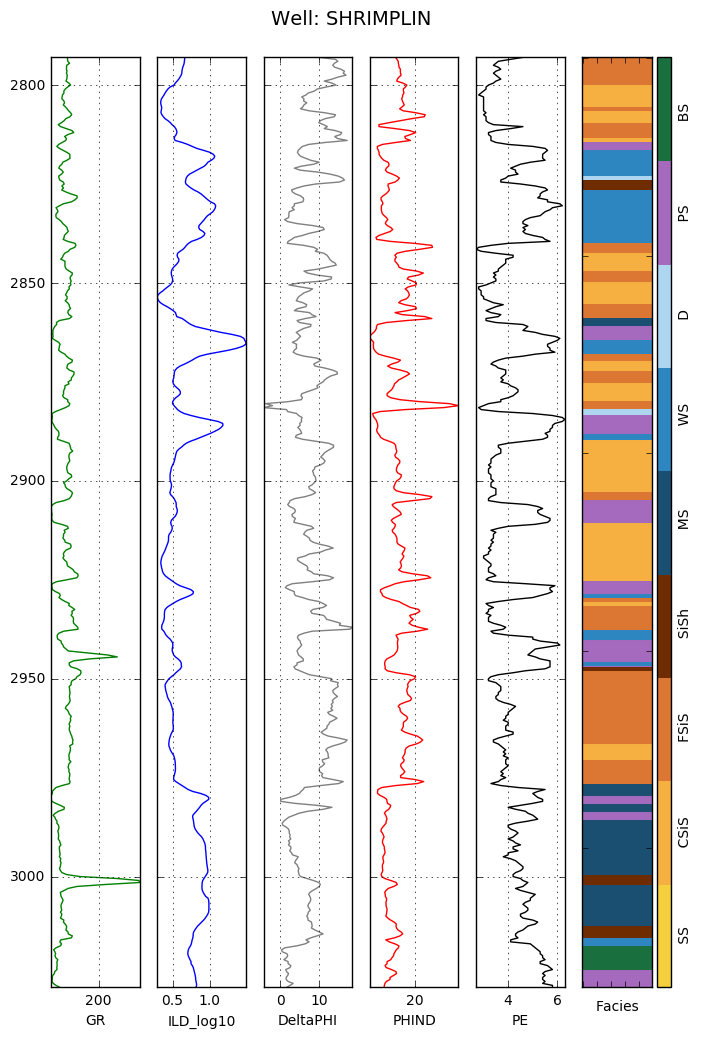

In [6]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

Next: make labels and features vectors

In [7]:
y = training_data['Facies'].values
X = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1).values
feat_labels =training_data.columns[4:]
label_encoded_y  = np.unique(y)
X

array([[ 77.45 ,   0.664,   9.9  , ...,   4.6  ,   1.   ,   1.   ],
       [ 78.26 ,   0.661,  14.2  , ...,   4.1  ,   1.   ,   0.979],
       [ 79.05 ,   0.658,  14.8  , ...,   3.6  ,   1.   ,   0.957],
       ..., 
       [ 49.719,   0.964,   2.925, ...,   3.19 ,   2.   ,   0.669],
       [ 51.469,   0.965,   3.083, ...,   3.152,   2.   ,   0.661],
       [ 50.031,   0.97 ,   2.609, ...,   3.295,   2.   ,   0.653]])

import and initilize a few classifires that we play with 

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1)
forest = RandomForestClassifier(criterion = 'entropy', n_estimators = 300, random_state=0, n_jobs=-1)
bag = BaggingClassifier(base_estimator = tree, n_estimators=400,random_state=0)
knn = KNeighborsClassifier(n_neighbors = 5, p=2, metric = 'minkowski')

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
SVC_classifier = svm.SVC(kernel = 'rbf', random_state=0, gamma=0.01)
pipe_svm = Pipeline([('scl',StandardScaler()),('clf',SVC_classifier)])

In [10]:
import xgboost
from xgboost import XGBClassifier
xg = XGBClassifier(n_estimators=300)

/home/evgeny/.conda/envs/py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Split the training data into training and test sets. Let's use 10% of the data for the test set.

In [11]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X,y, test_size=0.1, random_state=42)

In [12]:
# the scores 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
pre_scorer= make_scorer(score_func=f1_score, greater_is_better=True,average = 'micro')
#the scorer is f1_scrore with micro averaging, i.e.
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=7)
# stratified kfold cross-validation keeps the classes balanced in each fold.

In [13]:
from sklearn.model_selection import GridSearchCV

## check feature importance with random forest classifier

In [14]:
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1 , 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) NM_M                           0.187773
 2) GR                             0.164883
 3) PE                             0.150623
 4) ILD_log10                      0.143209
 5) PHIND                          0.140923
 6) RELPOS                         0.106821
 7) DeltaPHI                       0.105768


Looks like all features are nearly equally important

## Next 3 cells may take several minutes to evaluate.
I commented them out, and redefiened the classifiers bellow
with the calcualated parameters

### We tune the svm classifier by rinning a grid search to locate highest scoring hyperparameters 


update the svn classifier with these params:

## Tune XGBoost classifier

In [ ]:
parm_grid={'n_neighbors': [1,3,5,10],          }

grid_search = GridSearchCV(knn,
                           param_grid=parm_grid,
                           scoring = pre_scorer, 
                           n_jobs = -1, cv = kfold)
            
grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))         


In [127]:
knn = grid_search.best_estimator_
knn.fit(X_train,y_train)
print('Predicted F1-Score: {}'.format(knn.score(X_test,y_test)))

Predicted F1-Score: 0.5277777777777778


## I select here explicietely the parameters found by GridSearchCV, This is to save time on repeated runs

In [19]:
SVC_classifier = svm.SVC(kernel = 'rbf', random_state=0, gamma=1, C=30)
pipe_svm = Pipeline([('scl',StandardScaler()),('clf',SVC_classifier)])
xg = XGBClassifier(n_estimators=500, learning_rate=0.5)


### The combined majority vote classifier is constructed out of 3-individual classifiers

In [20]:
from sklearn.ensemble import VotingClassifier
mv = VotingClassifier(estimators=[('forest',forest),('XGBoost',xg),('svn',pipe_svm)])

In [17]:

clf_labels = [ 'Random Forest', 'KNN' ,'XGBoost','SVN', 'Majority-Vote']

print('10-fold cross validation:\n')
for clf, label in zip([forest,knn,xg,pipe_svm,mv], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=kfold,
                             scoring=pre_scorer)
    print("F1-score: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

F1-score: 0.74 (+/- 0.02) [Random Forest]
F1-score: 0.51 (+/- 0.02) [KNN]
F1-score: 0.71 (+/- 0.01) [XGBoost]
F1-score: 0.74 (+/- 0.02) [SVN]
F1-score: 0.74 (+/- 0.02) [Majority-Vote]


In [43]:
mv.fit(X_train,y_train)
print('Predicted F1-Score: {}'.format(mv.score(X_test,y_test)))

Predicted F1-Score: 0.7777777777777778


In [44]:
y_pred=mv.predict(X_test)
print('Predicted F1-Score: {}'.format(f1_score(y_true=y_test,y_pred=y_pred, average='micro')))

Predicted F1-Score: 0.7777777777777778


Some more detailes metrics to evaluate how good our classifier is doing.  A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array.  The entries of confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`.  

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics.  See the file `classification_utilities.py` in this repo for the `display_cm()` function.

In [22]:
predicted_labels=mv.predict(X_test)

In [23]:
from sklearn.metrics import confusion_matrix

In [28]:
from classification_utilities import display_cm, display_adj_cm
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS'];

In [29]:
conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    16     4     2                                        22
     CSiS     2    65    10                                        77
     FSiS          15    46                             1          62
     SiSh                 1    17                       1          19
       MS                       1    17     2           3          23
       WS                       5     3    38     1     6          53
        D                       1     1           8     2          12
       PS                             2     8          30          40
       BS                                               1    15    16

Precision  0.89  0.77  0.78  0.71  0.74  0.79  0.89  0.68  1.00  0.78
   Recall  0.73  0.84  0.74  0.89  0.74  0.72  0.67  0.75  0.94  0.78
       F1  0.80  0.81  0.76  0.79  0.74  0.75  0.76  0.71  0.97  0.78




The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [30]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

In [31]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [32]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.777778
Adjacent facies classification accuracy = 0.947531


In [26]:
display_adj_cm(conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    20           2                                        22
     CSiS          77                                              77
     FSiS                61                             1          62
     SiSh                 1    17                       1          19
       MS                            20                 3          23
       WS                       5          48                      53
        D                       1     1          10                12
       PS                             2                38          40
       BS                                                    16    16

Precision  1.00  1.00  0.95  0.74  0.87  1.00  1.00  0.88  1.00  0.95
   Recall  0.91  1.00  0.98  0.89  0.87  0.91  0.83  0.95  1.00  0.95
       F1  0.95  1.00  0.97  0.81  0.87  0.95  0.91  0.92  1.00  0.95


Considering adjacent facies, the `F1` scores for all facies types are above 0.9, except when classifying `SiSh` or marine siltstone and shale.  The classifier often misclassifies this facies (recall of 0.87), most often as wackestone. 

## Now we can train the classifier using the entire data set

In [33]:
mv.fit(X,y)
print('Predicted F1-Score: {}'.format(mv.score(X,y)))

Predicted F1-Score: 0.9978341584158416


## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [35]:
well_data = pd.read_csv('../validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
X_unknown = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1).values

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [36]:
#predict facies of unclassified data
y_unknown = mv.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,2
5,A1 SH,STUART,2810.5,73.955,0.667,6.900,12.250,3.086,1,0.889,2
6,A1 SH,STUART,2811.0,77.962,0.674,6.500,12.450,3.092,1,0.867,2
7,A1 SH,STUART,2811.5,83.894,0.667,6.300,12.650,3.123,1,0.844,2
8,A1 SH,STUART,2812.0,84.424,0.653,6.700,13.050,3.121,1,0.822,2
9,A1 SH,STUART,2812.5,83.160,0.642,7.300,12.950,3.127,1,0.800,2


In [37]:
well_data['Well Name'].unique()

[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

We can use the well log plot to view the classification results along with the well logs.

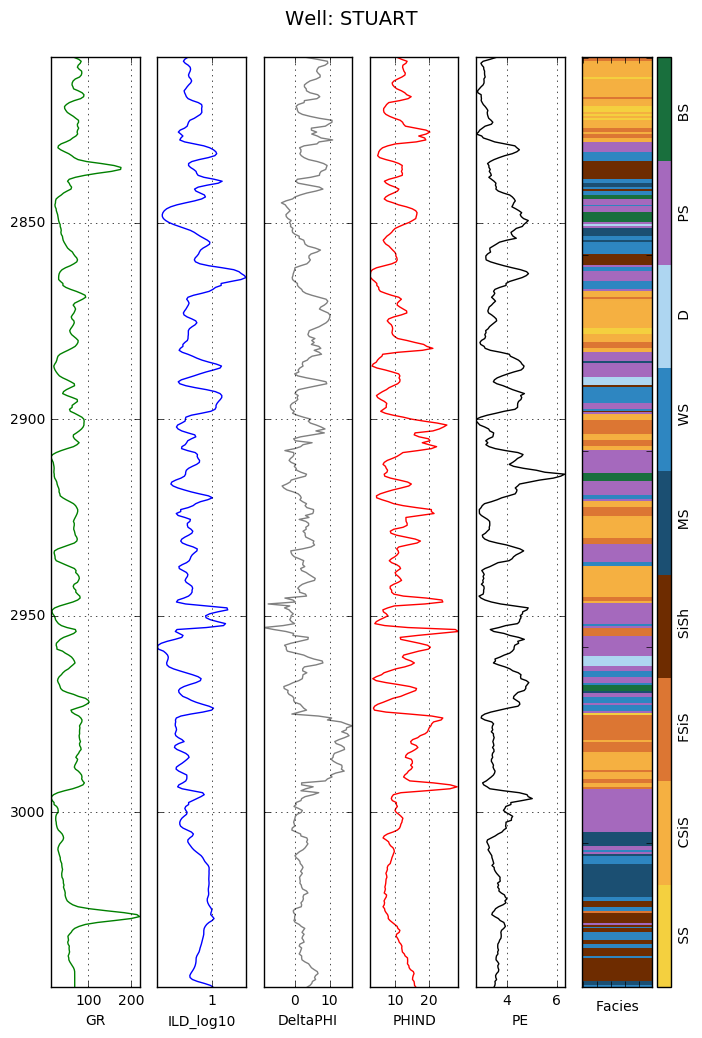

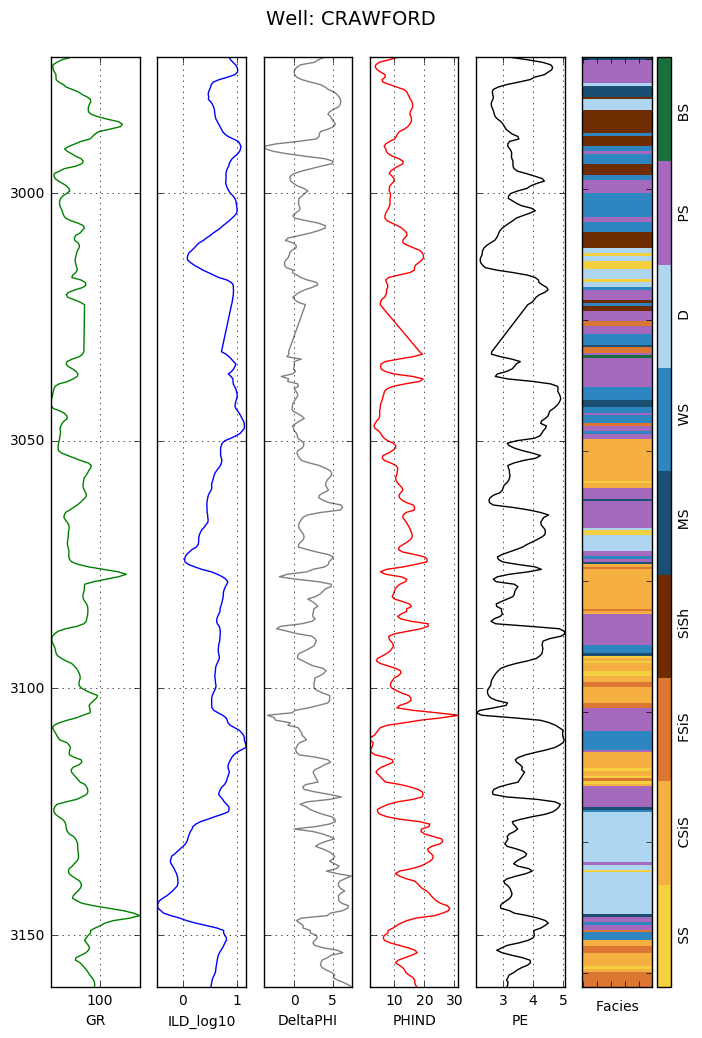

In [38]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

Finally we can write out a csv file with the well data along with the facies classification results.

In [39]:
well_data.to_csv('well_data_with_facies.csv')